In [1]:
# =========================================================
# Nested NPIV with RKHS estimators (sequential & joint)
# =========================================================

import os
import sys
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from threadpoolctl import threadpool_limits

# Avoid native BLAS/OpenMP oversubscription (CV/linear algebra can spawn threads)
threadpool_limits(1)

# ------------------------------------------------------------------
# Repo-specific imports (adjust the path if your layout is different)
# ------------------------------------------------------------------
sys.path.append(str(Path.cwd() / "../../simulations"))
import dgps_nested as dgps  # noqa: E402

from nnpiv.rkhs import (  # keep imports minimal to exactly what we use
    ApproxRKHSIVCV,
    RKHSIV,
    RKHSIVL2,
    RKHS2IV,
    RKHS2IVL2,
)

# ---------
# Settings
# ---------
plt.style.use("seaborn-v0_8-white")
plt.rcParams["figure.dpi"] = 120

def seed_everything(seed: int = 123) -> None:
    """Reproducibility for NumPy (and scikit via CV)."""
    np.random.seed(seed)

seed_everything(123)

# =========================================================
# Data generation 
# =========================================================
# Function dictionary (for reference):
# {'abs': 0, '2dpoly': 1, 'sigmoid': 2, 'sin': 3, 'frequent_sin': 4, 'abs_sqrt': 5,
#  'step': 6, '3dpoly': 7, 'linear': 8, 'rand_pw': 9, 'abspos': 10, 'sqrpos': 11,
#  'band': 12, 'invband': 13, 'steplinear': 14, 'pwlinear': 15, 'exponential': 16}

fn_number = 0
tau_fn = dgps.get_tau_fn(fn_number)

# A, D are first stage (endog + instruments); B, C are second stage; Y is outcome
A, D, B, C, Y, tau_fn = dgps.get_data(3000, 10, 10, tau_fn, 2)

# ---------------------------------------
# Build test grid (vary B[:,0] for plots)
# ---------------------------------------
def make_test_grid(X: np.ndarray, var_idx: int = 0, n: int = 1000,
                   q_low: float = 5.0, q_high: float = 95.0) -> np.ndarray:
    """
    Sweep one coordinate (var_idx) between given quantiles; hold others at median.
    Returns a grid sorted by the swept coordinate.
    """
    grid = np.tile(np.median(X, axis=0, keepdims=True), (n, 1))
    grid[:, var_idx] = np.linspace(
        np.percentile(X[:, var_idx], q_low),
        np.percentile(X[:, var_idx], q_high),
        n,
    )
    return grid[np.argsort(grid[:, var_idx])]

B_test = make_test_grid(B, var_idx=0, n=1000)
true_fn = tau_fn(B_test)  # ground-truth structural function h(B)

# ---------------------------------------------------------
# Sequential nested NPIV using RKHS-style models
# ---------------------------------------------------------
def nested_npivfit(
    A: np.ndarray, B: np.ndarray, C: np.ndarray, D: np.ndarray, Y: np.ndarray,
    B_test: np.ndarray,
    model, fitargs: dict | None = None
) -> np.ndarray:
    """
    Two-step baseline:
      Stage 1: fit g(A) using instruments D
      Stage 2: fit h(B) using instruments C, target = g_hat(A)

    `model` must implement .fit(Z, T, Y) and .predict(T_new) for both stages.
    """
    # Rename for clarity
    A1, B1, A2, B2 = A, B, D, C

    # Stage 1: estimate g(A) with instruments D
    if fitargs is not None:
        model.fit(A2, A1, Y, **fitargs)
    else:
        model.fit(A2, A1, Y)
    g_hat = model.predict(A1).reshape(A1.shape[0], -1)

    # Stage 2: estimate h(B) with instruments C, target = g_hat(A)
    if fitargs is not None:
        model.fit(B2, B1, g_hat, **fitargs)
    else:
        model.fit(B2, B1, g_hat)

    y_pred_test = model.predict(B_test).reshape(B_test.shape[0], -1)
    return y_pred_test

In [2]:
# -----------------------------
# Models & predictions
# -----------------------------
# Cross-validated Nystrom approximation (sequential)
approxrkhs_model = ApproxRKHSIVCV(
    kernel_approx="nystrom", n_components=200,
    kernel="rbf", gamma=0.1, delta_scale="auto",
    delta_exp=0.4, alpha_scales=np.geomspace(1, 10000, 10), cv=5
)
approxrkhs_pred = nested_npivfit(A, B, C, D, Y, B_test, model=approxrkhs_model)

# Plain RKHS IV (sequential)
rkhs_model = RKHSIV(kernel="rbf", gamma=0.1, delta_scale="auto", delta_exp=0.4)
rkhs_pred = nested_npivfit(A, B, C, D, Y, B_test, model=rkhs_model)

# RKHS IV with L2 (sequential)
rkhsl2_model = RKHSIVL2(kernel="rbf", gamma=0.1, delta_scale="auto")
rkhsl2_pred = nested_npivfit(A, B, C, D, Y, B_test, model=rkhsl2_model)

# Joint (simultaneous) variants (one-shot fit)
rkhs2l2_model = RKHS2IVL2(kernel="rbf", gamma=0.1, delta_scale="auto", delta_exp=0.4)
rkhs2l2_pred = rkhs2l2_model.fit(A, B, C, D, Y).predict(B_test)

rkhs2_model = RKHS2IV(kernel="rbf", gamma=0.1, delta_scale="auto", delta_exp=0.4)
rkhs2_pred = rkhs2_model.fit(A, B, C, D, Y).predict(B_test)

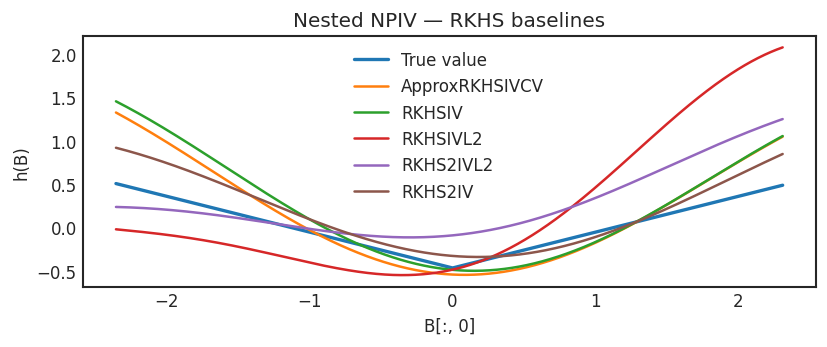

In [3]:
# ----------
# Plotting
# ----------
plt.figure(figsize=(7, 3))
plt.plot(B_test[:, 0], true_fn, label="True value", linewidth=2)
plt.plot(B_test[:, 0], approxrkhs_pred.ravel(), label="ApproxRKHSIVCV")
plt.plot(B_test[:, 0], rkhs_pred.ravel(), label="RKHSIV")
plt.plot(B_test[:, 0], rkhsl2_pred.ravel(), label="RKHSIVL2")
plt.plot(B_test[:, 0], rkhs2l2_pred.ravel(), label="RKHS2IVL2")
plt.plot(B_test[:, 0], rkhs2_pred.ravel(), label="RKHS2IV")
plt.xlabel("B[:, 0]")
plt.ylabel("h(B)")
plt.legend(frameon=False)
plt.title("Nested NPIV — RKHS baselines")
plt.tight_layout()
plt.show()